### Importing relevant libraries and packages

In [2]:
import numpy as np
import pandas as pd
import functools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import os
# for dirname, _, filenames in os.walk('../KBC/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
%matplotlib inline

random_seed = 42

**Reading all sheets directly into an ordered dictionary**

In [3]:
sheets_dict = pd.read_excel('../KBC/data.xlsx', sheet_name=None)
# Dropping the description sheet
del sheets_dict['Description']

In [3]:
sheets_dict.keys()

dict_keys(['Soc_Dem', 'Products_ActBalance', 'Inflow_Outflow', 'Sales_Revenues'])

**Merging the sheets 'Soc_Dem', 'Products_ActBalance', 'Inflow_Outflow' and 'Sales_Revenue into one dataframe**

In [4]:
data = functools.reduce(lambda left,right: pd.merge(left,right, on ='Client', 
                                                    how ='outer', sort = True),sheets_dict.values())

In [5]:
# Printing the number of rows and columns
print(data.shape)

(1615, 36)


**Making client id column as the index column of the dataset**

In [6]:
data.set_index('Client',inplace = True)
data.head()

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
1,F,51,7,1,NaN,NaN,1.0,NaN,NaN,1333.802857,...,30.0,3.0,12.0,9.0,1.0,0.0,0.0,26.972679,0.0,0.0
2,M,43,152,1,1.0,NaN,NaN,NaN,NaN,110.768571,...,6.0,2.0,2.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,M,17,140,1,NaN,1.0,NaN,NaN,NaN,482.654643,...,3.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,M,24,153,1,1.0,NaN,NaN,1.0,NaN,1599.840714,...,36.0,6.0,12.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
5,F,58,200,1,1.0,NaN,NaN,NaN,NaN,5353.483929,...,41.0,4.0,17.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN


**Checking data information including the index dtype and columns, non-null values and memory usage.**

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1615 entries, 1 to 1615
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           1612 non-null   object 
 1   Age                           1615 non-null   int64  
 2   Tenure                        1615 non-null   int64  
 3   Count_CA                      1615 non-null   int64  
 4   Count_SA                      426 non-null    float64
 5   Count_MF                      306 non-null    float64
 6   Count_OVD                     419 non-null    float64
 7   Count_CC                      170 non-null    float64
 8   Count_CL                      135 non-null    float64
 9   ActBal_CA                     1615 non-null   float64
 10  ActBal_SA                     426 non-null    float64
 11  ActBal_MF                     306 non-null    float64
 12  ActBal_OVD                    419 non-null    float64
 13  Act

### Checking for Null values

In [8]:
print(data.isna().sum())

Sex                                3
Age                                0
Tenure                             0
Count_CA                           0
Count_SA                        1189
Count_MF                        1309
Count_OVD                       1196
Count_CC                        1445
Count_CL                        1480
ActBal_CA                          0
ActBal_SA                       1189
ActBal_MF                       1309
ActBal_OVD                      1196
ActBal_CC                       1445
ActBal_CL                       1480
VolumeCred                        28
VolumeCred_CA                     28
TransactionsCred                  28
TransactionsCred_CA               28
VolumeDeb                         28
VolumeDeb_CA                      28
VolumeDebCash_Card                28
VolumeDebCashless_Card            28
VolumeDeb_PaymentOrder            28
TransactionsDeb                   28
TransactionsDeb_CA                28
TransactionsDebCash_Card          28
T

In [9]:
# Displaying the rows where Sex column contains NaN
data[data['Sex'].isna()]

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
843,NaN,36,151,1,NaN,NaN,NaN,NaN,NaN,80.928571,...,23.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.000000
953,NaN,50,35,1,1.0,NaN,NaN,NaN,NaN,1507.695714,...,18.0,0.0,3.0,7.0,0.0,0.0,1.0,0.0,0.0,15.222143
1363,NaN,38,8,1,NaN,NaN,NaN,NaN,NaN,6533.868571,...,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


### Handling Missing Values

There are different number of NaN values for many columns. 

- The **'Sex'** column contains 3 NaN values. There are ways to handle missing values for categorical column. But we have a dataset of 1615 entries so, we can ignore these clients information at the moment.
- The columns related to counts of active live accounts have many NaN values, it is because the clients have no such active accounts. Also, for columns containing account balances for inactive accounts, the entries for these columns are assumed to be 0.
- For columns containing transactions/volume of transactions, the assumption is that no transactions were made. Hence, these NaN values are also substituted with 0.

Imputing these missing values will result in a model with random guessing.

In [10]:
# Dropping the clients information where Sex contains NaN values
data.drop(data.loc[data['Sex'].isnull()].index, inplace=True)

In [11]:
# Substituting the NaNs with 0
data.loc[:,'Age':'TransactionsDeb_PaymentOrder'] = data.loc[:,'Age':'TransactionsDeb_PaymentOrder'] .fillna(0) 

In [12]:
data.isna().sum()

Sex                               0
Age                               0
Tenure                            0
Count_CA                          0
Count_SA                          0
Count_MF                          0
Count_OVD                         0
Count_CC                          0
Count_CL                          0
ActBal_CA                         0
ActBal_SA                         0
ActBal_MF                         0
ActBal_OVD                        0
ActBal_CC                         0
ActBal_CL                         0
VolumeCred                        0
VolumeCred_CA                     0
TransactionsCred                  0
TransactionsCred_CA               0
VolumeDeb                         0
VolumeDeb_CA                      0
VolumeDebCash_Card                0
VolumeDebCashless_Card            0
VolumeDeb_PaymentOrder            0
TransactionsDeb                   0
TransactionsDeb_CA                0
TransactionsDebCash_Card          0
TransactionsDebCashless_Card

### Checking for Duplicate Values

In [13]:
print('Number of duplicate records in the data: {}'.format(len(data[data.duplicated()])))

Number of duplicate records in the data: 0


### Handling categorical variable: Sex

In [14]:
%%time
#Dictionary to map the values
my_dict = {'F': 0, 'M': 1}
data['Sex'] = data['Sex'].map(my_dict)

Wall time: 3.01 ms


In [15]:
data['Sex'].value_counts()

1    856
0    756
Name: Sex, dtype: int64

In [16]:
data.head()

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
1,0,51,7,1,0.0,0.0,1.0,0.0,0.0,1333.802857,...,30.0,3.0,12.0,9.0,1.0,0.0,0.0,26.972679,0.0,0.0
2,1,43,152,1,1.0,0.0,0.0,0.0,0.0,110.768571,...,6.0,2.0,2.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,1,17,140,1,0.0,1.0,0.0,0.0,0.0,482.654643,...,3.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1,24,153,1,1.0,0.0,0.0,1.0,0.0,1599.840714,...,36.0,6.0,12.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
5,0,58,200,1,1.0,0.0,0.0,0.0,0.0,5353.483929,...,41.0,4.0,17.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN


### Data Exploration

**Let's display some statistical details**

In [17]:
data.describe()

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,...,1612.000000,1612.000000,1612.000000,1612.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000
mean,0.531017,42.851737,101.408189,1.078784,0.307692,0.887717,0.259926,0.105459,0.099256,2438.101514,...,13.359801,1.956576,5.151985,4.518610,0.199586,0.250259,0.298862,1.928997,2.718437,3.595933
std,0.499192,18.565762,64.903220,0.333328,0.567802,3.875201,0.438730,0.307239,0.361148,7078.342695,...,12.989881,2.701468,8.347502,5.201611,0.399896,0.433386,0.457996,9.953503,17.711309,7.741740
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.000000,44.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.267589,...,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,41.000000,97.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,461.399464,...,10.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,57.000000,151.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2174.675893,...,19.000000,3.000000,7.000000,7.000000,0.000000,0.500000,1.000000,0.000000,0.035714,4.625000
max,1.000000,97.000000,273.000000,4.000000,5.000000,79.000000,1.000000,1.000000,5.000000,171575.889643,...,83.000000,25.000000,60.000000,34.000000,1.000000,1.000000,1.000000,220.488214,407.962500,133.275357


**Let's plot the distribution of each attribute**

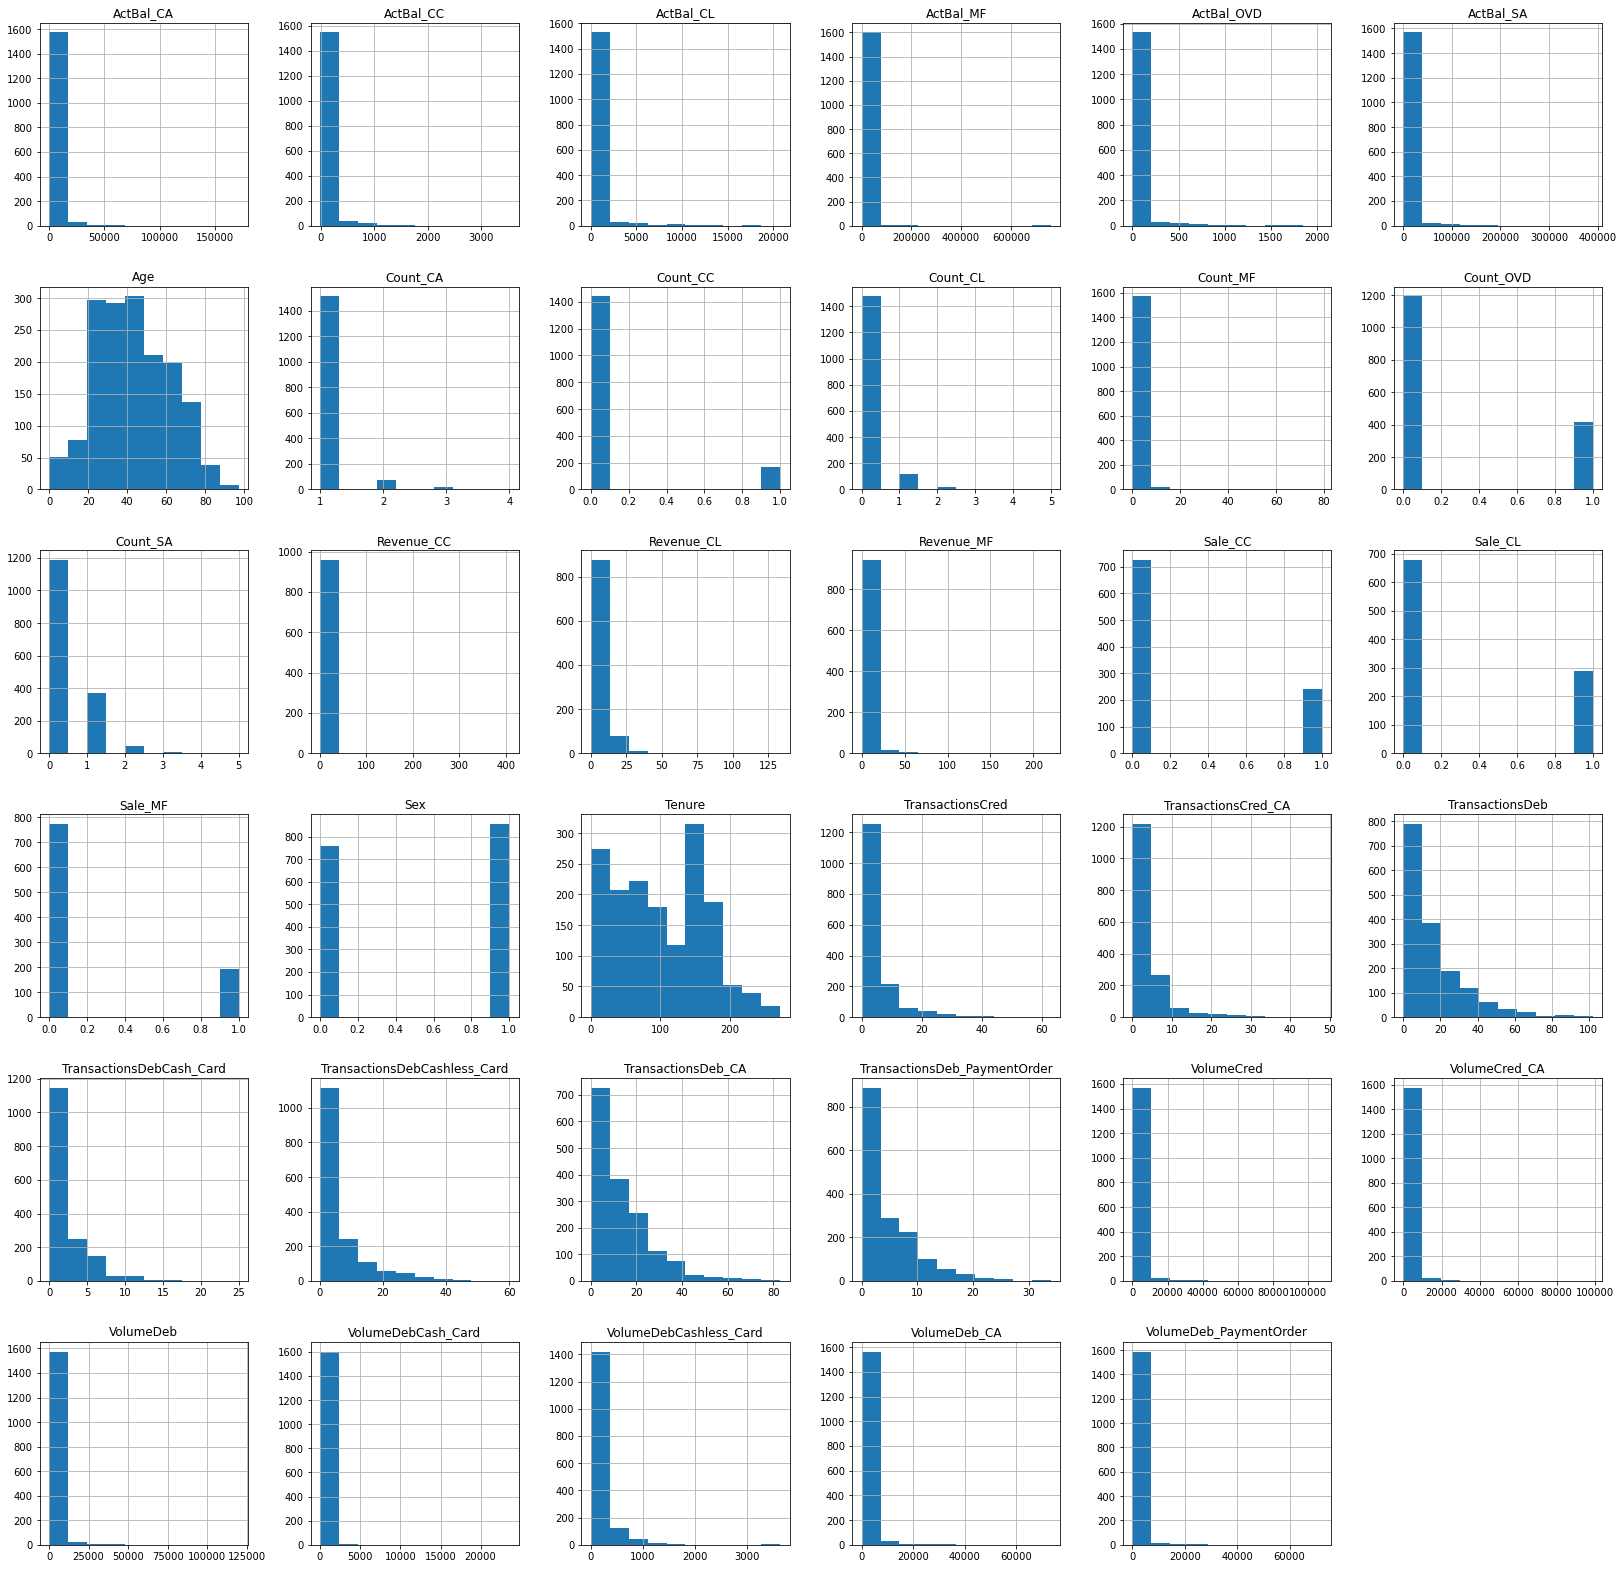

In [18]:
data.hist(figsize=(28,28))
plt.show()

Looking at the individual distributons of the different field above we can observe that there is something strange with 'Age' field. Let's examine it further.

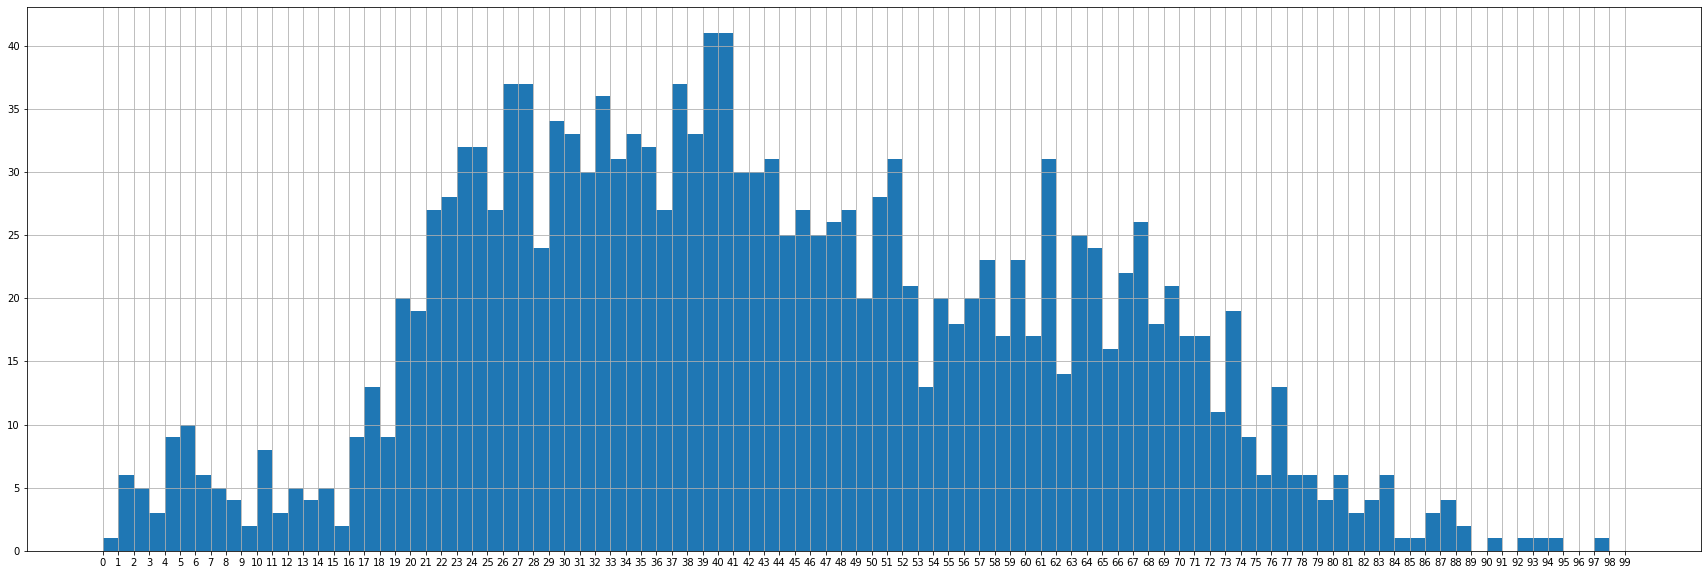

In [19]:
data['Age'].hist(bins = range(100), figsize = (30,10))
plt.xticks(range(100))
plt.show()

In [20]:
data[data['Age'] < 18].sort_values(by = 'Age').head()

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
158,1,0,152,1,1.0,0.0,0.0,0.0,0.0,326.630357,...,13.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
316,0,1,211,1,0.0,0.0,0.0,0.0,0.0,22.733571,...,21.0,6.0,1.0,9.0,0.0,0.0,1.0,0.0,0.000000,15.015357
638,1,1,31,1,0.0,0.0,1.0,0.0,0.0,89.250000,...,9.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000
391,1,1,16,1,0.0,0.0,0.0,1.0,1.0,172.581429,...,18.0,4.0,0.0,6.0,0.0,0.0,0.0,0.0,0.000000,0.000000
322,0,1,92,1,1.0,0.0,0.0,0.0,0.0,2175.270000,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.785714,0.000000


In [21]:
data[data['Age']<data['Tenure']//12].head()

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
23,1,4,160,1,2.0,4.0,1.0,0.0,0.0,22.967143,...,33.0,1.0,26.0,6.0,0.0,0.0,1.0,0.0,0.0,8.250000
158,1,0,152,1,1.0,0.0,0.0,0.0,0.0,326.630357,...,13.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
225,1,14,187,1,0.0,0.0,1.0,0.0,0.0,345.686071,...,5.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,8.130714
300,0,5,87,1,0.0,0.0,0.0,0.0,0.0,0.000000,...,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,12.035714
316,0,1,211,1,0.0,0.0,0.0,0.0,0.0,22.733571,...,21.0,6.0,1.0,9.0,0.0,0.0,1.0,0.0,0.0,15.015357


This distribution revealed an interesting revelations about the age of account holders. 

**Firstly**, there are clients who are younger and are not responsible enough to operate an account for example: customers aged between 0-10. After referring to KBC bank's website, I found that it is possible for a parent to open a current account for their child from age 10. 

**Secondly**, some of the customers are younger than than the tenure of their account with the bank which is highly unlikely. For example there is a client with ID: 158 whose Age is 0 years and Tenure with the bank is 152 months has one current and savings account.

**Considering the following points gathered online:**

- The KBC overdraft is subject to repayment capacity, financial status and is not available to persons under 18 years of age.
- The KBC Personal Loan is subject to repayment capacity, financial status and is not available to persons under 18 years of age.
- Credit facilities are subject to repayment capacity and financial status and are not available to persons under 18 years of age.
- KBC current account holders can invest in mutual funds.

Our target is to find clients who can be targeted for Mutual funds, Credit Cards and Consumer Loan. And from the observations above it can be assumed that it makes sense to target clients who are 18 or above 18 years of age. Although, the clients who are younger than 18 are eligible for mutual funds but usually the account is for pocket money purposes or teachning young how to manage their expenses which is  majorly handled by their parents, it won't be of any use to target those clients. The entries where tenure is larger than the age could be considered as random errors. The entries where client is below 18 years of age and where age is less than the tenure of account, accounts for almost 8% of our dataset.

There are various methods we can adopt to deal with this situation:

- We can delete this entry from the dataset as it is possible that the data points might be inaccurate
- We impute the values in Age/Tenure column by first replacing the values with NaNs and then impute them using models such as MICE and KNN. These methods could result in biased estimates.

Considering the size of our dataset and above points it's more reasonable to remove these entries as imputing methods could result in biased estimates. If we had been dealing with a large dataset then we could have used MICE/KNN as this would have a less impact on the prediction quality of our model.

In [22]:
# Removing the entries with Age < 18 and Tenure value greater than Age.
print('Entries Removed: {}'.format(len(data[data['Age'] < 18])+len(data[data['Age'] < data['Tenure']//12])))
data.drop(data[data['Age'] < 18].index, inplace=True)
data.drop(data[data['Age'] < data['Tenure']//12].index, inplace=True)

Entries Removed: 142


We still have NaNs value in our target variables viz. 'Sale_MF', 'Revenue_MF', 'Sale_CC', 'Revenue_CC' and 'Sale_CL' and 'Revenue_CL'. It's because these clients don't have sales and revenues associated with them and these will be the entries we'll try to predict. The remaining entries will be our training dataset which accounts for 60% of our dataset.

**Separating the training and targeting sets**

In [23]:
# Target Set
target_df = data[data.isnull().any(axis=1)]
print(target_df.shape)

(605, 35)


In [24]:
# Train Set
train_df = data.drop(data.loc[data['Sale_MF'].isnull()].index)
print(train_df.shape)

(906, 35)


**Random Forests** were used because these can model non-linear relationships. Random forest adds additional randomness to the model, while growing the trees. Instead of searching for the most important feature while splitting a node, it searches for the best feature among a random subset of features. This results in a wide diversity that generally results in a better model. They can be applied to both classification and regression tasks and are wildly used

**The step of normalizing the data has been skipped beacuse Random Forest is a tree-based model and hence does not require normalization (feature scaling)**.

### Functions used for Modelling

**Function for model evaluation for Sales**

In [25]:
def cross_val_sale(X,y,**params):
    
    '''
    Function to test many models and find winners
    return: DataFrame of predictions
    '''
    X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                      test_size=0.2,
                                                      random_state=random_seed, 
                                                      shuffle = True)
    class_weights = compute_class_weight('balanced', classes=[0, 1], y = y_train)
    model = RandomForestClassifier(**params,class_weight={c: class_weights[c] for c in [0,1]},
                                  random_state = random_seed)
    kfold = KFold(n_splits=5, shuffle=True, random_state = random_seed)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring='accuracy')
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    y_train_pred = clf.predict(X_train)
    print('Training set metrics:')
    print('Accuracy: ', accuracy_score(y_train, np.round(y_train_pred)))
    print('Precision:', precision_score(y_train, np.round(y_train_pred)))
    print('Recall:   ', recall_score(y_train, np.round(y_train_pred)))
    print('AUC:      ', roc_auc_score(y_train, np.round(y_train_pred)))
    print('----------------------------------------------')
    print('Test set metrics:')
    print('Accuracy: ', accuracy_score(y_val, np.round(y_pred)))
    print('Precision:', precision_score(y_val, np.round(y_pred)))
    print('Recall:   ', recall_score(y_val, np.round(y_pred)))
    print('AUC:      ', roc_auc_score(y_val, np.round(y_pred)))
    return clf

**Function for model evaluation for Revenue**

In [26]:
def cross_val_revenue(X,y,**params):
    
    '''
    Function to test many models and find winners
    return: DataFrame of predictions
    '''
    X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                      test_size = 0.2,
                                                      random_state = random_seed, 
                                                      shuffle = True)
    model = RandomForestRegressor(**params, criterion ='mse', 
                                  random_state = random_seed)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    y_train_pred = clf.predict(X_train)
    print('RMSE (Training set): %0.2f' % mean_squared_error(y_train_pred, y_train, squared=False))
    print('RMSE (Test set):     %0.2f\n' % mean_squared_error(y_pred, y_val, squared=False))
    return clf

**Function for visualizing permutation feature importance**

We measure the importance of a feature by calculating the increase in the model's prediction error after permuting the feature. A feature is "important" if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. A feature is "unimportant" if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction.

In [27]:
def visualize_importance(model, df_X, df_Y):
    result = permutation_importance(model,
                                    df_X, df_Y,
                                    n_repeats=10, n_jobs=2,
                                    random_state = random_seed)
    
    sorted_idx = result.importances_mean.argsort()
    fig, ax = plt.subplots(figsize =(20,10))
    ax.barh(df_X.columns[sorted_idx],
            result.importances[sorted_idx].mean(axis =1).T),
    ax.set_title("Permutation Importances")
    fig.tight_layout()
    plt.show()
    return sorted_idx

**Function for visualizing partial independence plots**

A partial dependence (PD) plot depicts the functional relationship between a small number of input variables and predictions. They show how the predictions partially depend on values of the input variables of interest.

In [28]:
def partial_dependence(model, df_X, sorted_idx, threshold=10):
    fig, ax = plt.subplots(figsize=(30, 5))
    ax.set_title("%d Most important features" % threshold)
    plot_partial_dependence(model, df_X,
                            df_X.columns[sorted_idx][::-1][:threshold],
                            n_cols=threshold,
                            n_jobs=-1,
                            grid_resolution=100, ax=ax)

### Handling Imbalance

It is essential to handle the imbalance because the algorithm will be more biased towards predicting the majority class. The algorithm will not have enough data to learn the patterns present in the minority class. Here, the imbalance in the dataset has been handled by using **compute_class_weight** function available in the scikit-learn library. This function sets a high weight on the minority class and it will be used more frequently when training the model. This can ensure that the model isn't overfitting to the majority class.

The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class. Using the parameter **balanced**, the model automatically assigns the class weights inversely proportional to their respective frequencies.

This method is not used with XGBoost as Gradient Boosting algorithms deals with class imbalance by constructing successive training sets based on incorrectly classified examples.

### Propensity Models

### 1) Consumer Loan

**Preparing the training and testing dataset for Consumer Loan**

In [29]:
loan_df = train_df.drop(['Sale_MF','Sale_CC',
                   'Revenue_MF','Revenue_CC'], axis = 1)
loan_df.head()

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_CL,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
1,0,51,7,1,0.0,0.0,1.0,0.0,0.0,1333.802857,...,250.000000,283.089286,247.607143,50.0,30.0,3.0,12.0,9.0,0.0,0.0
2,1,43,152,1,1.0,0.0,0.0,0.0,0.0,110.768571,...,307.142857,38.407143,35.714286,6.0,6.0,2.0,2.0,1.0,0.0,0.0
6,0,24,19,1,0.0,0.0,0.0,0.0,1.0,4.297143,...,357.142857,0.000000,0.000000,8.0,6.0,1.0,0.0,0.0,0.0,0.0
8,0,64,30,1,0.0,0.0,1.0,0.0,0.0,0.000000,...,253.571429,6.982143,0.000000,42.0,24.0,10.0,1.0,0.0,0.0,0.0
13,0,66,132,1,1.0,0.0,0.0,0.0,1.0,353.839643,...,339.285714,173.432143,312.535714,41.0,39.0,6.0,17.0,10.0,0.0,0.0


In [30]:
loan_train_x = loan_df.loc[:,:'TransactionsDeb_PaymentOrder']
loan_train_sale = loan_df['Sale_CL'].to_numpy().flatten()
loan_train_revenue = loan_df['Revenue_CL'].to_numpy().flatten()

#### 1.1) Consumer Loan Sale


In [31]:
model_cl_sale = cross_val_sale(loan_train_x, loan_train_sale,
                               criterion ='gini', n_estimators = 50,
                               min_samples_split = 35, min_samples_leaf = 6)

Training set metrics:
Accuracy:  0.888121546961326
Precision: 0.8092783505154639
Recall:    0.7810945273631841
AUC:       0.8551744147332173
----------------------------------------------
Test set metrics:
Accuracy:  0.7582417582417582
Precision: 0.6341463414634146
Recall:    0.4727272727272727
AUC:       0.6773085182534001


The value from the above metrics indicates that the Random Forest is performing good on train and test data. We can explore further to see that which features are important for the underlying model.

**Visualizing permutation feature importance**

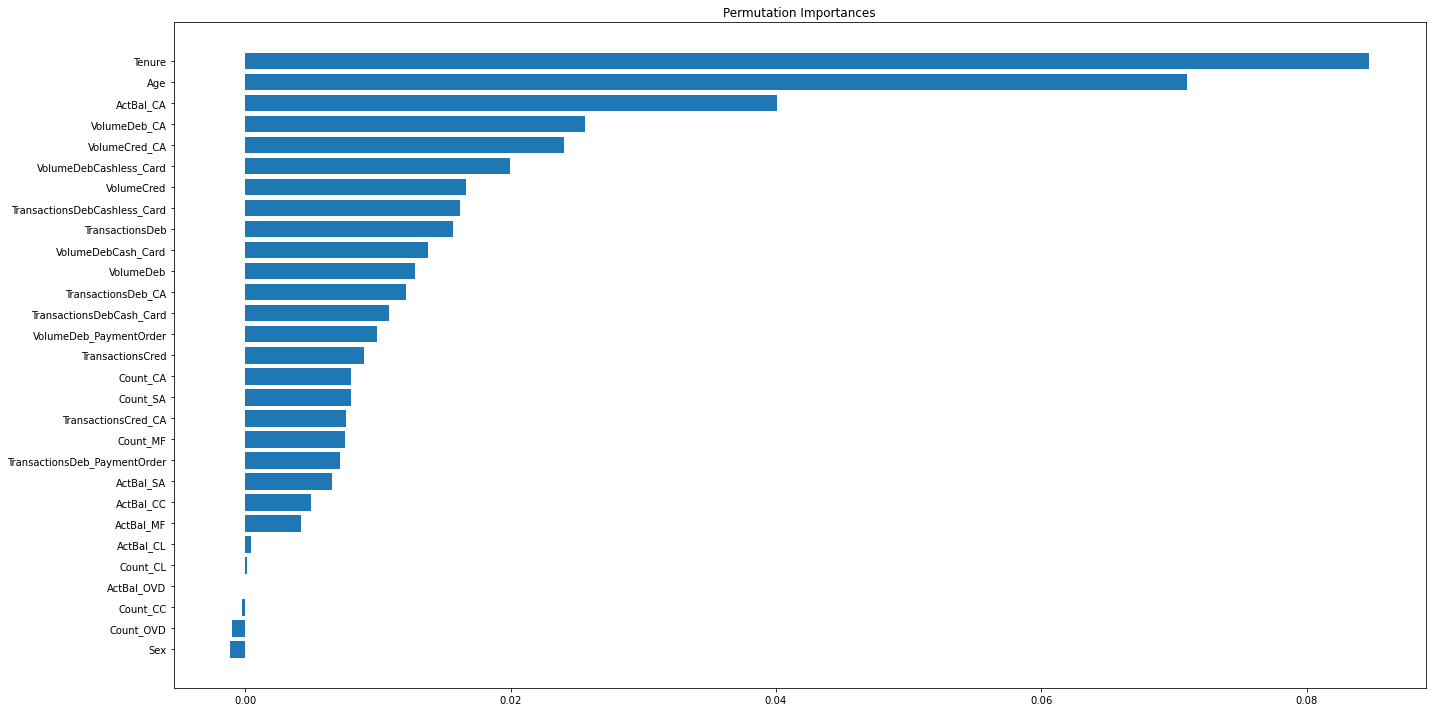

In [32]:
feature_importance_cl_sale = visualize_importance(model_cl_sale, loan_train_x, loan_train_sale)

Looking at the above bar plot of permutation feature importance, we can clearly see the most important features and how the random shuffling in feature value affects the model score. Features **Tenure, Age, Current account balance, Monthly debit and credit turnover on current accounts, Monthly number of debit cashless transactions via card, Monthly volume of debit cashless transactions via card** are among the most important features. But we'll not conclude here, plotting partial dependence plot could generate more insight about the feature importance for the model.

Let's visualise the partial dependence plot for top 10 features from the permutation importance algorithm.

**Visualizing partial dependence**

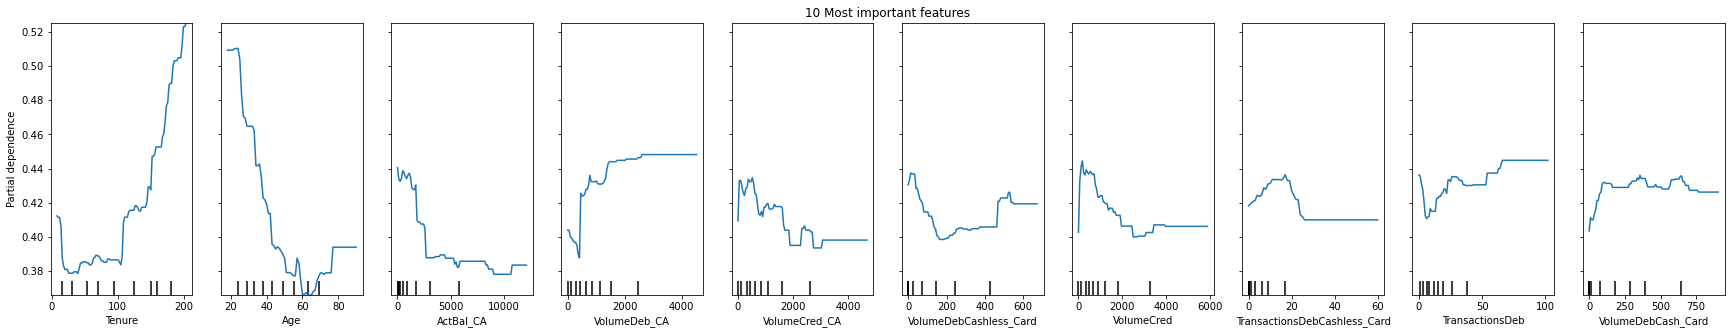

In [33]:
partial_dependence(model_cl_sale, loan_train_x, feature_importance_cl_sale)

From the above plots we can see that clients with longer tenure with the bank and the clients who are younger or are retired are most favoured by the model. Also, clients with less current account balance, more number of debit cashless transactions, less credit turnover, substantial amount of monthly debit transactions on current account and more montly debit turnover are favoured by the model. 

So, the features which are important to predict the propensity of a customer to buy consumer loan are : **Tenure, Age, ActBal_CA, VolumeDeb_CA, VolumeCred_CA, VolumeDebCashless_Card, VolumeCred, TransactionsDebCashless_Card, TransactionsDeb and VolumeDebCash_Card.** These features makes sense as the customers who are young and retired are usually the one with less account balance and low source of income. Also, the clients who are an old customer will be favoured over the new ones. The other features like credit turnover, debit turnover and the number of transactions are important to understand the buying patterns of the customer. The clients with these features are likely to spend more money. So, from the available dataset it can be concluded that these features should be analysed while lending a loan to a customer.

#### 1.2) Consumer Loan Revenue

The following is a regression task because the output target is a continous value.

In [34]:
model_cl_revenue = cross_val_revenue(loan_train_x, loan_train_revenue,n_estimators = 10)

RMSE (Training set): 2.56
RMSE (Test set):     11.38



RMSE which stands for **Root Mean Squared Error** has been used to evaluate the performance of our models. It is the square root of value obtained from Mean Square Error function. Error is the difference between the actual and predicted value. The effect of each error on the overall value is proportional to the size of the squared error. Therefore, larger errors have a disproportionately large effect on RMSE.

**Visualizing permutation feature importance**

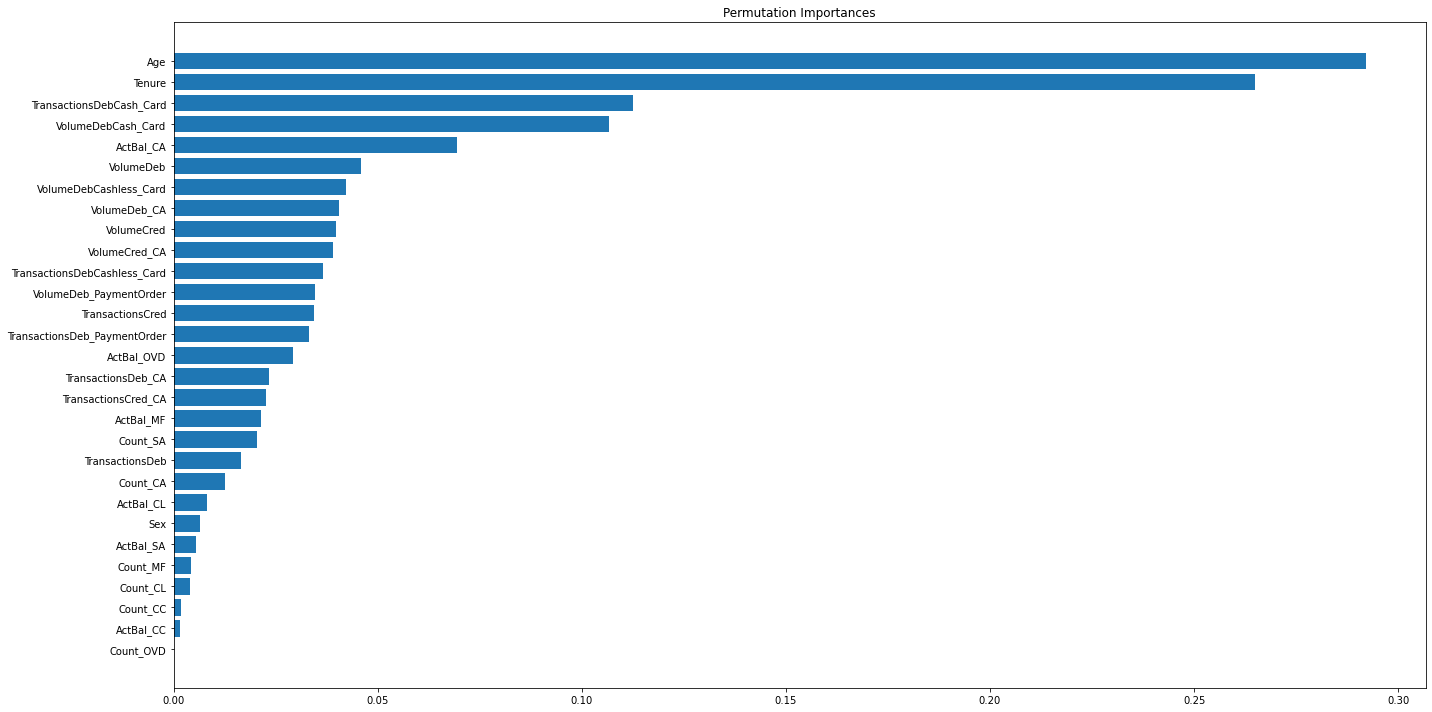

In [35]:
feature_importance_cl_revenue = visualize_importance(model_cl_revenue, loan_train_x, loan_train_revenue)

**Visualizing partial dependence**

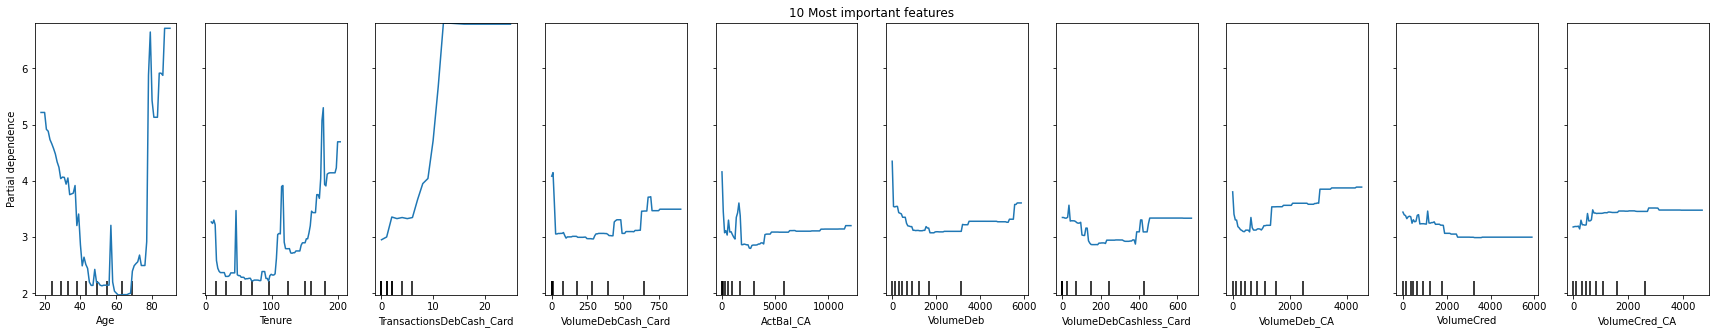

In [36]:
partial_dependence(model_cl_revenue, loan_train_x, feature_importance_cl_revenue)

As expected, it can be clearly seen from the above visualizations that it is the same number of features that drives the behaviour of our regression model, with a little change in their order of occurence. But in nutshell the features are similar. 

### 2) Mutual Fund

**Preparing the training and testing dataset for Consumer Loan**

In [37]:
fund_df = train_df.drop(['Sale_CC','Sale_CL',
                   'Revenue_CC','Revenue_CL'], axis = 1)

In [38]:
fund_df.head()

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Revenue_MF
Client,,,,,,,,,,,,,,,,,,,,,
1,0,51,7,1,0.0,0.0,1.0,0.0,0.0,1333.802857,...,250.000000,283.089286,247.607143,50.0,30.0,3.0,12.0,9.0,1.0,26.972679
2,1,43,152,1,1.0,0.0,0.0,0.0,0.0,110.768571,...,307.142857,38.407143,35.714286,6.0,6.0,2.0,2.0,1.0,0.0,0.000000
6,0,24,19,1,0.0,0.0,0.0,0.0,1.0,4.297143,...,357.142857,0.000000,0.000000,8.0,6.0,1.0,0.0,0.0,0.0,0.000000
8,0,64,30,1,0.0,0.0,1.0,0.0,0.0,0.000000,...,253.571429,6.982143,0.000000,42.0,24.0,10.0,1.0,0.0,0.0,0.000000
13,0,66,132,1,1.0,0.0,0.0,0.0,1.0,353.839643,...,339.285714,173.432143,312.535714,41.0,39.0,6.0,17.0,10.0,0.0,0.000000


In [39]:
fund_train_x = fund_df.loc[:,:'TransactionsDeb_PaymentOrder']
fund_train_sale = fund_df['Sale_MF'].to_numpy().flatten()
fund_train_revenue = fund_df['Revenue_MF'].to_numpy().flatten()

#### 2.1) Mutual Fund Sale

In [40]:
model_fund_sale = cross_val_sale(fund_train_x, fund_train_sale,
                                 criterion ='gini', n_estimators = 50,
                                 min_samples_split = 50, min_samples_leaf = 10)

Training set metrics:
Accuracy:  0.8798342541436464
Precision: 0.6746987951807228
Recall:    0.7724137931034483
AUC:       0.8395747721993926
----------------------------------------------
Test set metrics:
Accuracy:  0.7692307692307693
Precision: 0.41379310344827586
Recall:    0.32432432432432434
AUC:       0.6035414725069898


**Visualizing permutation feature importance**

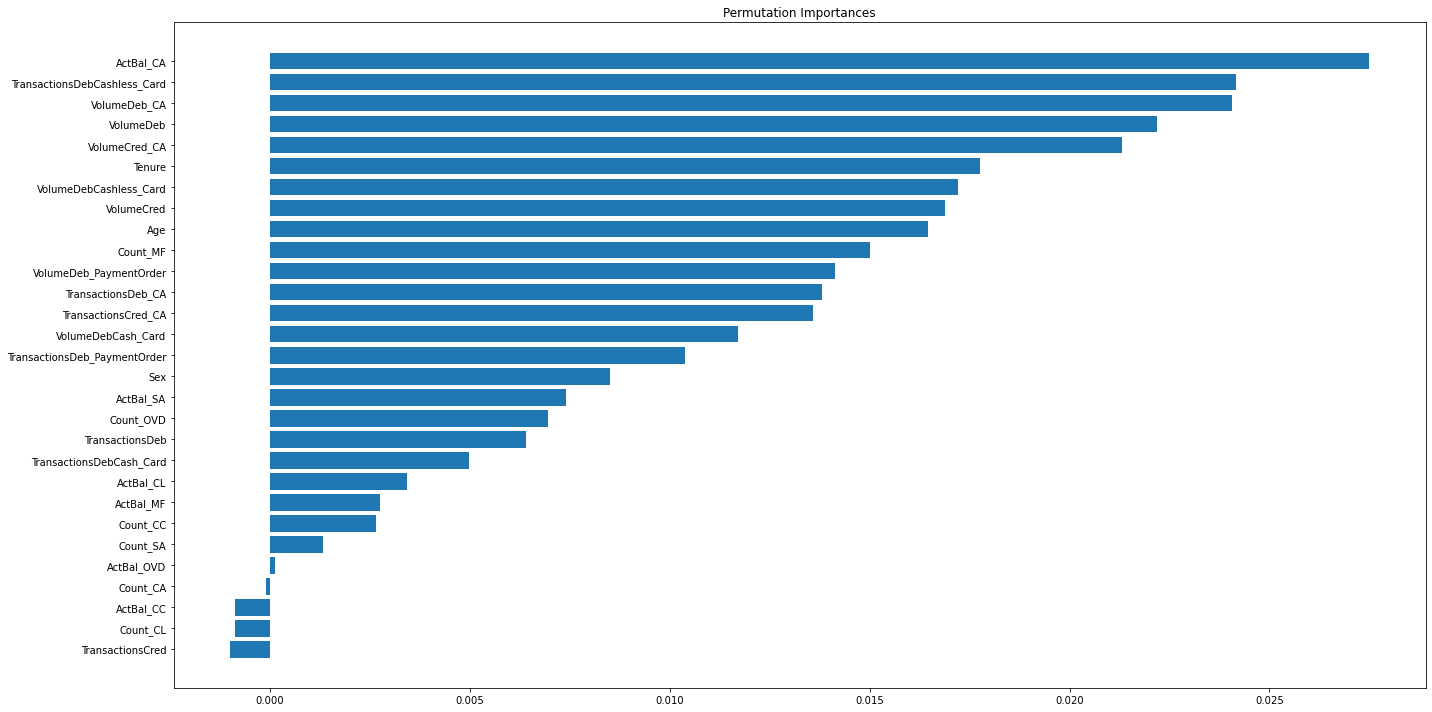

In [41]:
feature_importance_fund_sale = visualize_importance(model_fund_sale, fund_train_x, fund_train_sale)

The top 10 features to consider while predicting the probabiity of a consumer to buy a mutual funds are: **ActBal_CA, TransactionsDebCashless_Card, VolumeDeb_CA, VolumeDeb, VolumeCred_CA, Tenure, VolumeDebCashless_Card, VolumeCred, Age and Count_MF**.

Let's visualise the partial dependence plot for top 10 features from the permutation importance algorithm.

**Visualizing partial dependence**

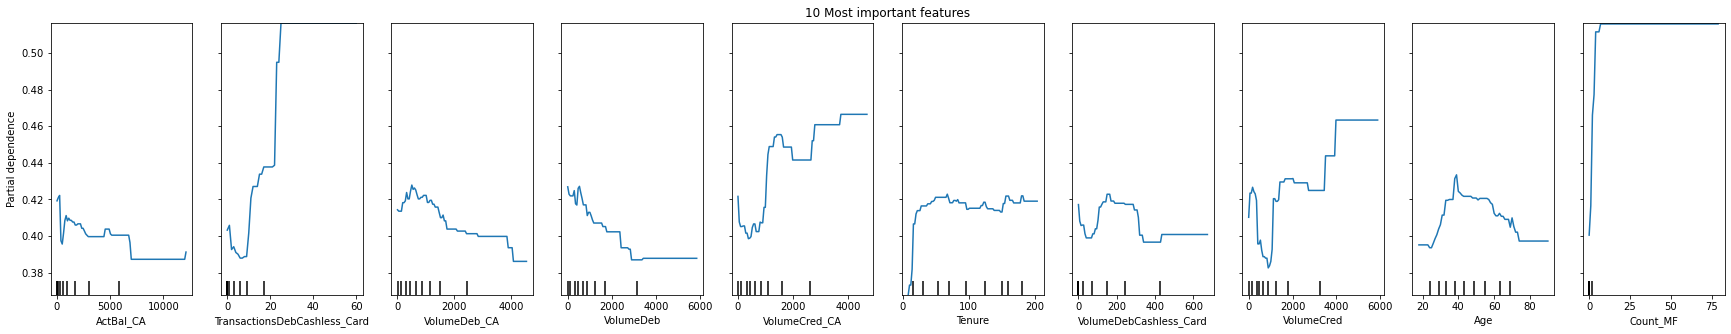

In [42]:
partial_dependence(model_fund_sale, fund_train_x, feature_importance_fund_sale)


From the above plots we can see that clients aged between 30 to 60 are more likely to buy mutual funds because clients within this age range tend to have regular income so, they are more interested in investing it. They tend to have a high number of existing mutual fun investments so, it is likely that they have a high risk taking ability and hence can be contacted with new offers. These clients tends to have a low monthly debit turnover and high credit turnover on current accounts. They tend to have a substantial amount of balance in their current account. So, these clients can be targeted with offers for mutual funds.

#### 2.2) Mutual Fund Revenue


In [43]:
model_fund_revenue = cross_val_revenue(fund_train_x, fund_train_revenue, 
                                       n_estimators = 20,max_depth=20)

RMSE (Training set): 3.20
RMSE (Test set):     11.17



**Visualizing permutation feature importance**

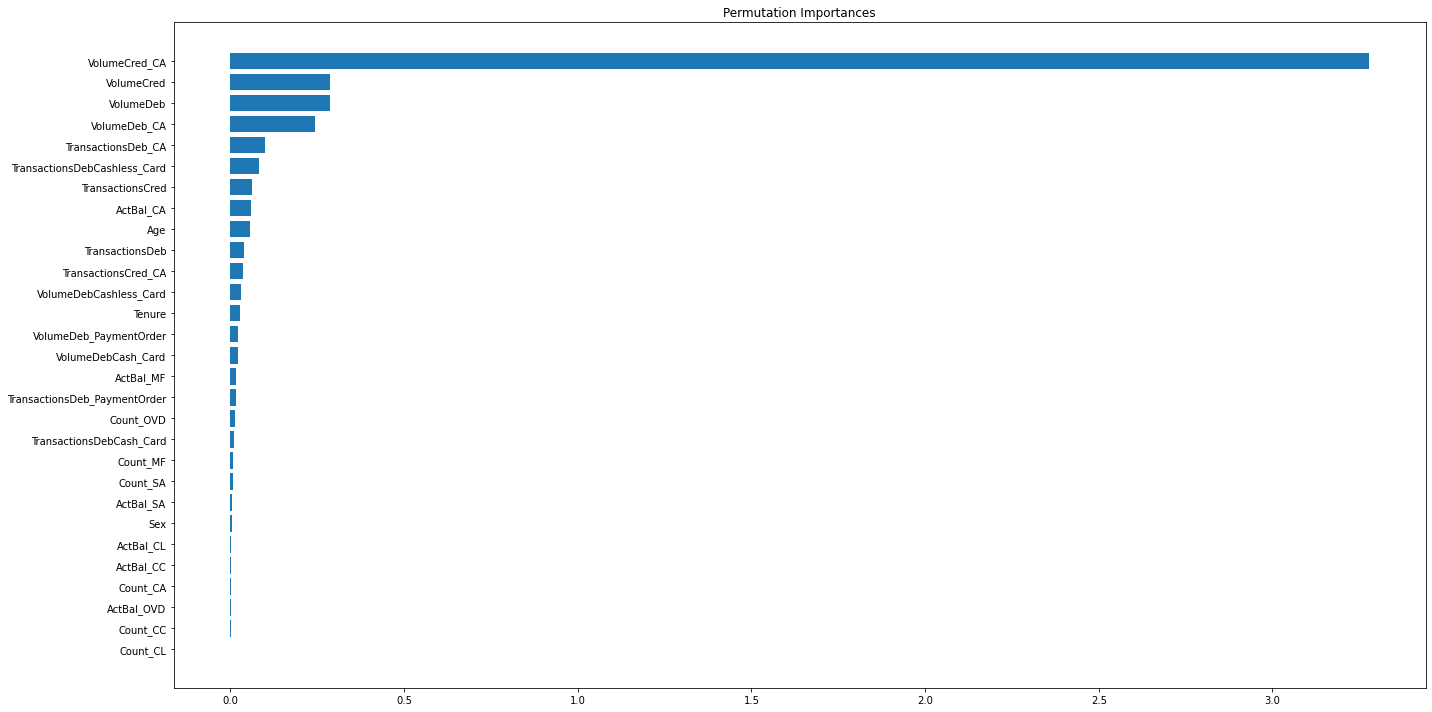

In [44]:
feature_importance_fund_revenue = visualize_importance(model_fund_revenue, fund_train_x, fund_train_revenue)

**Visualizing partial dependence**

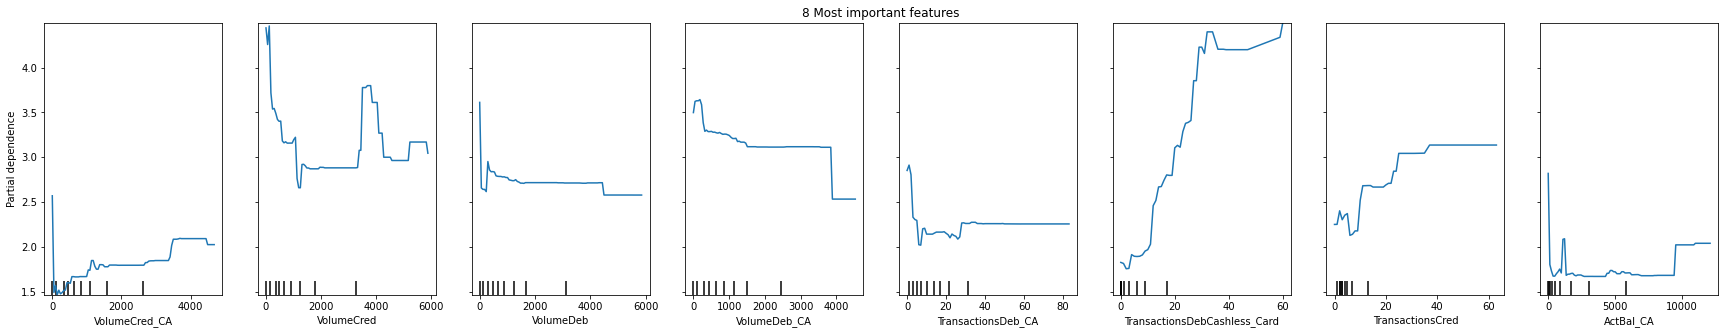

In [45]:
partial_dependence(model_fund_revenue, fund_train_x, feature_importance_fund_revenue, threshold = 8)

In general, we can say that the key features which are important for profitable clients are lower debit trunover and high credit turnover. Also, these clients tend to have a lower current account balance and high debit cashless transactions.

### 3) Credit Card

**Preparing the training and testing dataset for Consumer Loan**

In [46]:
card_df = train_df.drop(['Sale_MF','Sale_CL',
                         'Revenue_MF','Revenue_CL'], axis = 1)
card_df.head()

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_CC,Revenue_CC
Client,,,,,,,,,,,,,,,,,,,,,
1,0,51,7,1,0.0,0.0,1.0,0.0,0.0,1333.802857,...,250.000000,283.089286,247.607143,50.0,30.0,3.0,12.0,9.0,0.0,0.0
2,1,43,152,1,1.0,0.0,0.0,0.0,0.0,110.768571,...,307.142857,38.407143,35.714286,6.0,6.0,2.0,2.0,1.0,0.0,0.0
6,0,24,19,1,0.0,0.0,0.0,0.0,1.0,4.297143,...,357.142857,0.000000,0.000000,8.0,6.0,1.0,0.0,0.0,0.0,0.0
8,0,64,30,1,0.0,0.0,1.0,0.0,0.0,0.000000,...,253.571429,6.982143,0.000000,42.0,24.0,10.0,1.0,0.0,0.0,0.0
13,0,66,132,1,1.0,0.0,0.0,0.0,1.0,353.839643,...,339.285714,173.432143,312.535714,41.0,39.0,6.0,17.0,10.0,0.0,0.0


In [47]:
card_train_x = card_df.loc[:,:'TransactionsDeb_PaymentOrder']
card_train_sale = card_df['Sale_CC'].to_numpy().flatten()
card_train_revenue = card_df['Revenue_CC'].to_numpy().flatten()

#### 3.1) Credit Card Sale

In [48]:
model_card_sale = cross_val_sale(card_train_x, card_train_sale,
                                 criterion ='entropy', n_estimators = 50,
                                 min_samples_split = 50, min_samples_leaf = 3)

Training set metrics:
Accuracy:  0.8895027624309392
Precision: 0.7865853658536586
Recall:    0.7413793103448276
AUC:       0.838871473354232
----------------------------------------------
Test set metrics:
Accuracy:  0.7252747252747253
Precision: 0.6129032258064516
Recall:    0.3333333333333333
AUC:       0.6186666666666667


**Visualizing permutation feature importance**

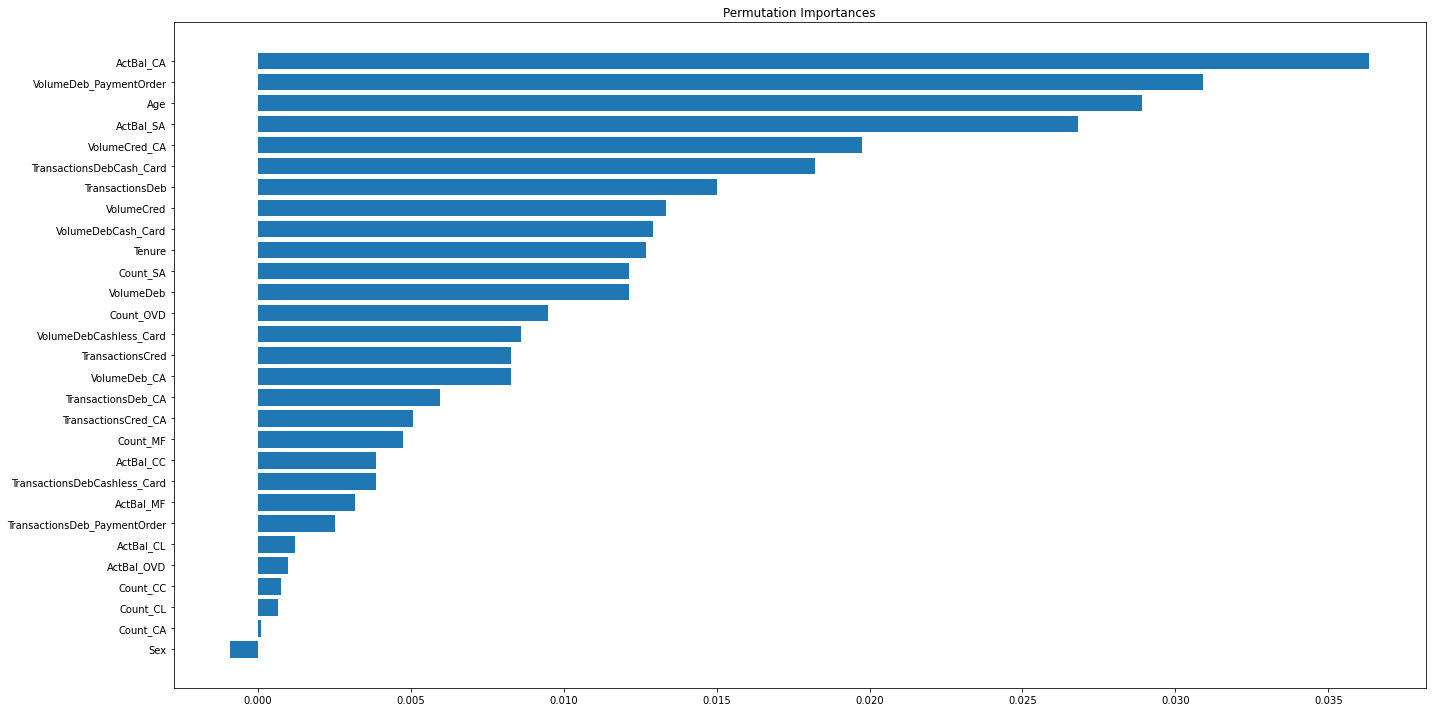

In [49]:
feature_importance_card_sale = visualize_importance(model_card_sale, card_train_x, card_train_sale)

The top 10 features important for predicting the propensity of a consumer to buy credit cards are **ActBal_CA, VolumeDeb_PaymentOrder, Age, ActBal_SA, VolumeCred_CA, TransactionsDebCash_Card, TransactionsDeb, VolumeCred, VolumeDebCash_Card and Tenure**.

Let's visualise the partial dependence plot for top 10 features from the permutation importance algorithm.

**Visualizing partial dependence**

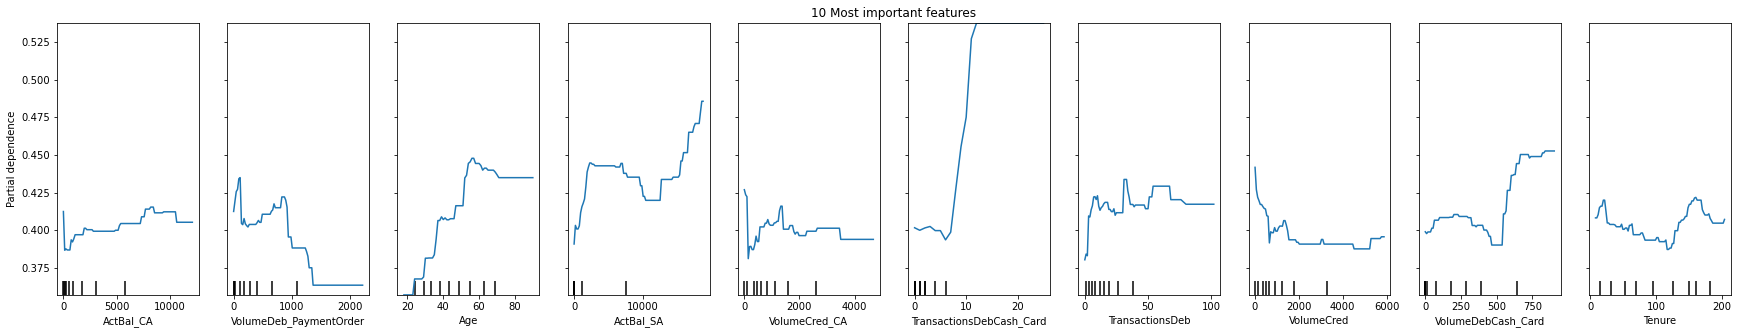

In [50]:
partial_dependence(model_card_sale, card_train_x, feature_importance_card_sale)

The features which are important for predicting the propensity of a consumer to buy a credit card are the balance in their current and savings account, age, debit transactions, volume of payment order and tenure. The clients likely to obtain a credit card are very new or very older clients of the bank with more than 2500 EUR in their current account and large sum over 8000 EUR in their savings account. Often clients who have more a good amount of savings and a high debit turn over and transactions are likely to use the credit card. These types of clients can be trusted with timely repayments which makes them suitable for such services.

#### 3.2) Credit Card Revenue

In [51]:
model_card_revenue = cross_val_revenue(card_train_x, card_train_revenue, n_estimators = 100)

RMSE (Training set): 4.96
RMSE (Test set):     31.93



**Visualizing permutation feature importance**

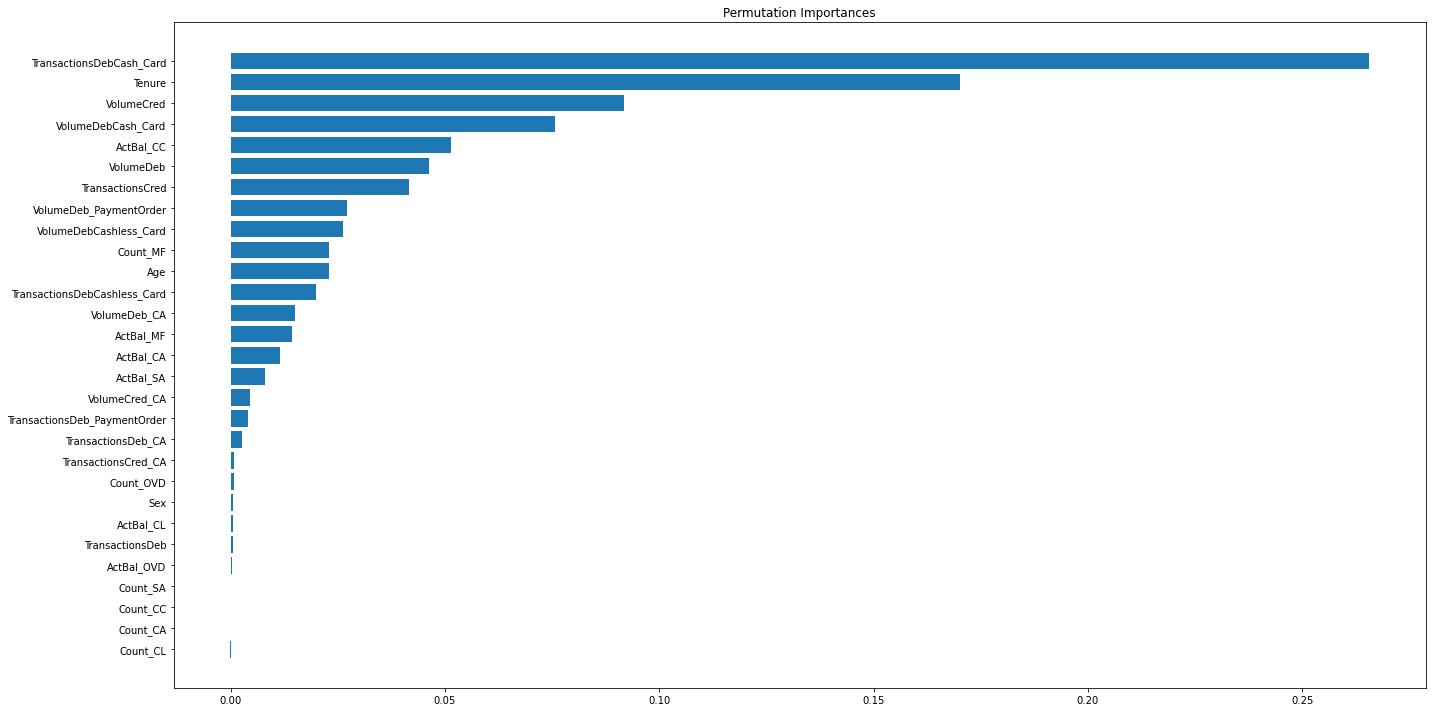

In [52]:
feature_importance_card_revenue = visualize_importance(model_card_revenue, card_train_x, card_train_revenue)

**Visualizing partial dependence**

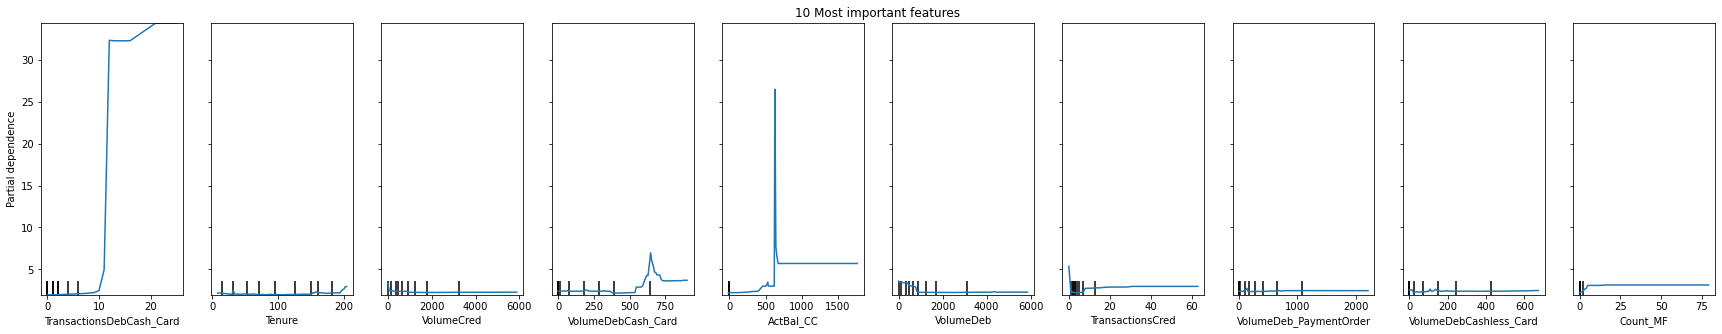

In [53]:
partial_dependence(model_card_revenue, card_train_x, feature_importance_card_revenue)

From the revenue model, we have a new feature which is of interest while selecting profitable clients - actual credit card balance. The clients with the balance in between 500-700EUR (approx) are more likely to buy a credit card. This feature is also important as it tells us whether the client would be able to handle an additional credit card or not. 

### 4) Client Targeting

Here, we will determine the set of clients to be targeted by the bank's direct marketing campaign. The bank has a capacity to target only 15% of the clients which we will determine on the basis of maximum revenue which will be generated if we target a particular client with a distinct offer. The maximum expected revenue of a client is the highest revenue value computed as the product of the probability of client purchasing a service and the expected revenue from that client.

**Consumer loan predictions**

In [54]:
predict_df = pd.DataFrame(data = target_df.index)

In [55]:
# Predicting the probability of a client purchasing a consumer loan
pred_cl_sale = model_cl_sale.predict_proba(target_df.loc[:,:'TransactionsDeb_PaymentOrder'])[:,1]
# Predicting the revenue from the client with loan
pred_cl_revenue = model_cl_revenue.predict(target_df.loc[:,:'TransactionsDeb_PaymentOrder'])
# Storing the predicted values in the dataframe
predict_df = predict_df.assign(pred_cl_sale = pred_cl_sale,
                               pred_cl_revenue = pred_cl_revenue,
                               expected_revenue_cl = pred_cl_sale*pred_cl_revenue)

**Consumer mutual fund predictions**

In [56]:
# Predicting the probability of a client purchasing a mutual fund
pred_mf_sale = model_fund_sale.predict_proba(target_df.loc[:,:'TransactionsDeb_PaymentOrder'])[:,1]
# Predicting the revenue from the client with loan
pred_mf_revenue = model_fund_revenue.predict(target_df.loc[:,:'TransactionsDeb_PaymentOrder'])
# Storing the predicted values in the dataframe
predict_df = predict_df.assign(pred_mf_sale = pred_mf_sale,
                               pred_mf_revenue = pred_mf_revenue,
                               expected_revenue_mf = pred_mf_sale*pred_mf_revenue)

**Consumer credit card predictions**

In [57]:
# Predicting the probability of a client purchasing a mutual fund
pred_cc_sale = model_card_sale.predict_proba(target_df.loc[:,:'TransactionsDeb_PaymentOrder'])[:,1]
# Predicting the revenue from the client with loan
pred_cc_revenue = model_card_revenue.predict(target_df.loc[:,:'TransactionsDeb_PaymentOrder'])
# Storing the predicted values in the dataframe
predict_df = predict_df.assign(pred_cc_sale = pred_cc_sale,
                               pred_cc_revenue = pred_cc_revenue,
                               expected_revenue_cc = pred_cc_sale*pred_cc_revenue)

In [58]:
# Setting the CLient column as the index
predict_df.set_index('Client',inplace = True)

### Finalising the target clients

**Finding the target offer and maximum revenue for a particular client**

In [59]:
# Targeted offer
predict_df = predict_df.assign(pred_offer = predict_df[['expected_revenue_cl',
                                                        'expected_revenue_mf',
                                                        'expected_revenue_cc']].idxmax(axis = 1))
# Maximum Revenue
predict_df = predict_df.assign(pred_revenue = predict_df[['expected_revenue_cl',
                                                          'expected_revenue_mf',
                                                          'expected_revenue_cc']].max(axis = 1))

In [60]:
# replace the columns starting with expected_revenue_ with the categories cc,cl and mf
predict_df.replace(regex=r'^expected_revenue_', value='', inplace=True)
# setting the 15 percent cut-off for marketing campaign
cut_off = int(0.15 * predict_df.shape[0])
target_clients = predict_df.sort_values(by='pred_revenue', ascending=False)[['pred_offer', 'pred_revenue']].head(cut_off)

In [61]:
#Checking the contribution of each product on offer
print("Expected revenue Generation for Consumer Loan: {:.2f} EUR".\
                                                  format(sum(target_clients['pred_revenue']\
                                                  [target_clients['pred_offer'] == 'cl'])))
print("Expected revenue Generation for Credit Card: {:.2f} EUR".\
                                                  format(sum(target_clients['pred_revenue']\
                                                  [target_clients['pred_offer'] == 'cc'])))
print("Expected revenue Generation for Mutual Fund: {:.2f} EUR".\
                                                  format(sum(target_clients['pred_revenue']\
                                                  [target_clients['pred_offer'] == 'mf'])))

Expected revenue Generation for Consumer Loan: 294.10 EUR
Expected revenue Generation for Credit Card: 314.74 EUR
Expected revenue Generation for Mutual Fund: 197.57 EUR


It can be observed that the credit card marketing contibutes most among all the campaigns.

In [62]:
print('Expected overall revenue generation: {:.2f} EUR'.format(sum(target_clients['pred_revenue'])))

Expected overall revenue generation: 806.41 EUR


In [63]:
with pd.option_context('display.max_rows', None):
    print(target_clients)

       pred_offer  pred_revenue
Client                         
766            mf     50.352256
84             cc     49.362095
373            cc     29.028371
1365           cc     24.990123
516            cc     20.932643
532            mf     20.644990
596            mf     19.113494
110            mf     17.993803
506            mf     16.960219
454            cc     16.407576
931            cc     16.289068
996            cc     15.790347
330            cc     13.409442
153            cc     12.459003
41             cl     11.808512
389            cc     11.288536
1455           cc     11.021280
1243           mf     10.432222
866            cc      9.722528
1207           mf      8.752097
562            cl      8.679444
197            cc      8.673318
1530           cl      8.605892
1119           cl      8.565558
674            cl      8.514759
828            cl      8.402819
314            mf      8.155211
1410           cc      8.136022
978            cc      8.084225
1132    

In [64]:
# Saving the target client list in a csv file
target_clients.to_csv('../KBC/target.csv')

### Further Enhancements

- Grid Search can be used for model selection and hyperparameter optimzation. There are various machine learning algorithms which can tested on our dataset apart from Random Forest like Logistic Regression, XGBoost, SVM etc. Apart from standard machine learning algorithms we can also use neural networks to achieve the targeted output.
- The dataset given for this task is very small. Usually for these kind of tasks a larger dataset would be more suitable. Further research can be carried out on a large dataset to find optimal and fine tuned solution.